# 점포 & 매출 EDA


---
**결과 요약**
1. 전체 점포 수
- <U>**2023 3분기 최신 데이터**</U> 확인결과, 점포수의 숫자나 변화를 이용할꺼면 미쳐 분리 못한 <U>**normal 지역의 상권이 많은 곳**</U>은 적절하게 처리해주는 과정이 필요할것으로 판단됨
- 젠트리 지역과 비젠트리 지역간의 시계열 변화율(2019 1분기, 2023년 3분기)을 확인한 결과, <U>**젠트리 지역은 <span style = "color:red">증가의 추세</span>, 비젠트리 지역은 <span style = "color:blue">감소의 추세</span>를 보이고 있음**</U>
- 해당 데이터는 어느 정도 유의미하다고 판단되서 회귀분석 진행했고 <U>**점포 800개 이상**인 상권의 통계적으로 유의미한 데이터(p < 0.05)를 확인한 결과</U>,<br/>위와 똑같이 <U>**젠트리 지역은 증가의 추세, 비젠트리 지역은 감소의 추세를 보이고 있음**</U>
- 추후 해당 지역의 상권변화에 p-value나 기울기는 feature로 사용이 가능하다고 판단됨

2. 프랜차이즈 점포
- 전체적으로 젠트리와 비젠트리 둘 다 <U>**프랜차이즈의 점포수는 계속 감소**</U>하는 추세
- <U>**점포간의 관계성을 찾기가 힘듬.**</U>
- 관계성을 찾기 위해서는 임대료에 관한 데이터가 필요할 것으로 예상됨.
- 근데 임대료 데이터 봐도... 그때 예전에 수미님이 하신거 보면 임대료는 상승중인데 점포는 떨어지는 중이니까. 살짝... 음의관계가 나와서 변수로는 사용이 불가능 할수 있음
- 그래도 다른 데이터간의 조합했을 때 확인해 봤을 때, 상관관계가 높게 나오면 적용은 가능할 것으로 보임
---


## 라이브러리 임포트


In [1]:
import os
import psycopg2
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv

In [2]:
# Warning 무시
warnings.filterwarnings('ignore', category=UserWarning)

# matplotlib 한글 폰트 설정
os.system('rm -rf ~/.cache/matplotlib')
os.system('fc-cache -fv')

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

/usr/share/fonts: caching, new cache contents: 0 fonts, 5 dirs
/usr/share/fonts/cMap: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap: caching, new cache contents: 0 fonts, 5 dirs
/usr/share/fonts/cmap/adobe-cns1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-gb1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-japan1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-japan2: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-korea1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/opentype: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/opentype/urw-base35: caching, new cache contents: 35 fonts, 0 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 4 dirs
/usr/share/fonts/truetype/dejavu: caching, new cache contents: 6 fonts, 0 dirs
/usr/share/fonts/truetype/droid: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts

## 데이터 불러오기


In [3]:
load_dotenv()

# DB 구성 객체
DB_CONFIG = {
    'host': os.getenv('DB_HOST', 'localhost'),
    'port': os.getenv('DB_PORT', 5432),
    'database': os.getenv('DB_NAME', 'postgres'),
    'user': os.getenv('DB_USER', 'postgres'),
    'password': os.getenv('DB_PASSWORD', 'postgres')
}

In [4]:
conn = psycopg2.connect(
    host=DB_CONFIG['host'],
    port=DB_CONFIG['port'],
    database=DB_CONFIG['database'],
    user=DB_CONFIG['user'],
    password=DB_CONFIG['password'],
    client_encoding='UTF8'
)

if conn is None:
  print("Connection failed")

### 점포 및 매출 데이터 로드


In [5]:
df_origin_biz_dist = pd.read_sql_query('SELECT * FROM position.seoul_biz_dist', conn)
df_origin_dong = pd.read_sql_query('SELECT * FROM position.seoul_biz_dist_dong_radius_500m', conn)
for year in range(2019, 2024):
  df_name = f"df_origin_store_{year}"
  globals()[df_name] = pd.read_sql_query(f'SELECT * FROM store.seoul_biz_dist_store_{year}', conn)
  print(f"생성된 데이터프레임: {df_name}")
for year in range(2019, 2024):
  df_name = f"df_origin_estimated_sales_{year}"
  globals()[df_name] = pd.read_sql_query(f'SELECT * FROM estimated_sales.seoul_biz_dist_estimated_sales_{year}', conn)
  print(f"생성된 데이터프레임: {df_name}")

생성된 데이터프레임: df_origin_store_2019
생성된 데이터프레임: df_origin_store_2020
생성된 데이터프레임: df_origin_store_2021
생성된 데이터프레임: df_origin_store_2022
생성된 데이터프레임: df_origin_store_2023
생성된 데이터프레임: df_origin_estimated_sales_2019
생성된 데이터프레임: df_origin_estimated_sales_2020
생성된 데이터프레임: df_origin_estimated_sales_2021
생성된 데이터프레임: df_origin_estimated_sales_2022
생성된 데이터프레임: df_origin_estimated_sales_2023


In [6]:
df_biz_dist = pd.json_normalize(df_origin_biz_dist['data'].tolist())
df_dong = pd.json_normalize(df_origin_dong['data'].tolist())
for year in range(2019, 2024):
  df_origin_name = f"df_origin_store_{year}"
  df_name = f"df_store_{year}"
  globals()[df_name] = pd.json_normalize(globals()[df_origin_name]['data'].tolist())
  print(f"JSON 정규화된 데이터프레임: {df_name}")
for year in range(2019, 2024):
  df_origin_name = f"df_origin_estimated_sales_{year}"
  df_name = f"df_estimated_sales_{year}"
  globals()[df_name] = pd.json_normalize(globals()[df_origin_name]['data'].tolist())
  print(f"JSON 정규화된 데이터프레임: {df_name}")

JSON 정규화된 데이터프레임: df_store_2019
JSON 정규화된 데이터프레임: df_store_2020
JSON 정규화된 데이터프레임: df_store_2021
JSON 정규화된 데이터프레임: df_store_2022
JSON 정규화된 데이터프레임: df_store_2023
JSON 정규화된 데이터프레임: df_estimated_sales_2019
JSON 정규화된 데이터프레임: df_estimated_sales_2020
JSON 정규화된 데이터프레임: df_estimated_sales_2021
JSON 정규화된 데이터프레임: df_estimated_sales_2022
JSON 정규화된 데이터프레임: df_estimated_sales_2023


## 데이터 전처리


In [7]:
# 전체 상권, 상권배우지 데이터 확인
com_list = df_biz_dist.copy()
com_list.head()

,상권구분코드,상권구분,상권코드,상권,x좌표,y좌표,자치구코드,자치구,행정동코드,행정동,영역면적
0,A,골목상권,3110008,배화여자대학교(박노수미술관),197093.0,453418.0,11110,종로구,11110515,청운효자동,149264.0
1,U,관광특구,3001494,종로·청계 관광특구,199796.0,452274.0,11110,종로구,11110615,종로1·2·3·4가동,653127.0
2,R,전통시장,3130021,신설종합시장,201854.0,452569.0,11110,종로구,11110710,숭인2동,9800.0
3,R,전통시장,3130002,세종마을음식문화거리(금천교시장),197423.0,453030.0,11110,종로구,11110530,사직동,49557.0
4,R,전통시장,3130001,통인시장,197351.0,453449.0,11110,종로구,11110515,청운효자동,38280.0


In [8]:
# 젠트로, 비젠트로 확인
site_com = df_dong.copy()
site_com.head()

,상권그룹,구분,상권구분코드,상권구분,상권코드,상권,시군구코드,시군구,행정동코드,행정동,법정동코드,법정동
0,강남역,비젠트리피케이션,D,발달상권,3120189,강남역,11650,서초구,11650520,서초2동,11650108,서초동
1,강남역,비젠트리피케이션,D,발달상권,3120189,강남역,11650,서초구,11650520,서초2동,11680101,역삼동
2,강남역,비젠트리피케이션,D,발달상권,3120197,역삼역,11680,강남구,11680640,역삼1동,11680101,역삼동
3,강남역,비젠트리피케이션,D,발달상권,3120187,신논현역,11680,강남구,11680521,논현1동,11650108,서초동
4,강남역,비젠트리피케이션,A,골목상권,3110954,국기원,11680,강남구,11680640,역삼1동,11680101,역삼동


In [9]:
site_name = site_com.drop_duplicates(subset='상권그룹')[['상권그룹', '구분']]
site_name.head()

,상권그룹,구분
0,강남역,비젠트리피케이션
5,압구정로데오,비젠트리피케이션
17,건대입구역,비젠트리피케이션
28,여의도역,비젠트리피케이션
29,동대문(DDP),비젠트리피케이션


In [10]:
gen_lst = site_name[site_name['구분'] == '젠트리피케이션']['상권그룹'].tolist()
gen_code_lst = site_name[site_name['구분'] == '젠트리피케이션']['상권그룹'].tolist()
non_gen_lst = site_name[site_name['구분'] == '비젠트리피케이션']['상권그룹'].tolist()

In [11]:
site_name.head()

,상권그룹,구분
0,강남역,비젠트리피케이션
5,압구정로데오,비젠트리피케이션
17,건대입구역,비젠트리피케이션
28,여의도역,비젠트리피케이션
29,동대문(DDP),비젠트리피케이션


In [12]:
com_df = site_com.drop_duplicates(subset='상권')[['상권', '상권그룹', '구분']]
com_df.head()

,상권,상권그룹,구분
0,강남역,강남역,비젠트리피케이션
2,역삼역,강남역,비젠트리피케이션
3,신논현역,강남역,비젠트리피케이션
4,국기원,강남역,비젠트리피케이션
5,성수대교남단,압구정로데오,비젠트리피케이션


In [13]:
com_category_lst = pd.merge(com_list, com_df, left_on='상권', right_on='상권', how='outer').rename({'상권그룹': '중첩지역'}, axis=1)
com_category_lst['구분'] = com_category_lst['구분'].fillna('normal')
com_category_lst.head()

,상권구분코드,상권구분,상권코드,상권,x좌표,y좌표,자치구코드,자치구,행정동코드,행정동,영역면적,중첩지역,구분
0,A,골목상권,3110346,4.19민주묘지역 2번,201112.0,461090.0,11305,강북구,11305645,우이동,60794.0,NaN,normal
1,D,발달상권,3120150,63빌딩,194670.0,446691.0,11560,영등포구,11560540,여의동,40709.0,NaN,normal
2,D,발달상권,3120098,DMC(디지털미디어시티),190266.0,453378.0,11440,마포구,11440740,상암동,347758.0,NaN,normal
3,A,골목상권,3111083,GS강동자이아파트,213004.0,448764.0,11740,강동구,11740685,길동,81524.0,NaN,normal
4,A,골목상권,3110722,G타워,190905.0,442315.0,11530,구로구,11530540,구로3동,84987.0,NaN,normal


이제 데이터는 대충 준비된거 같으니 시작해보자


## 점포 관련 데이터 분석


### 점포 관련 데이터 확인


In [14]:
site_name = site_com.drop_duplicates(subset=['상권그룹', '상권코드'])[['상권그룹', '상권코드', '상권', '구분']]
site_name.head()

,상권그룹,상권코드,상권,구분
0,강남역,3120189,강남역,비젠트리피케이션
2,강남역,3120197,역삼역,비젠트리피케이션
3,강남역,3120187,신논현역,비젠트리피케이션
4,강남역,3110954,국기원,비젠트리피케이션
5,압구정로데오,3120195,성수대교남단,비젠트리피케이션


In [15]:
# 병합구현
# 데이터보면 엄청 많아서 불러오고 전처리 하고 붙이고 과정이 필요할것으로 생각됨
total_type_close = pd.DataFrame(None)

for year in range(2019, 2024):  # 일단 귀찮으니까 매년 초를 기준으로 분석 뭔가 이상하다 싶으면 다르게도 합쳐서 분석가능
  total_type_close = pd.concat([total_type_close, globals()[f"df_store_{year}"]])
print(f'수집된 데이터는 {len(total_type_close)}개 입니다')
total_type_close.head()

columns = [
    '점포수', '유사업종점포수', '개업율', '개업점포수',
    '폐업률', '폐업점포수', '프랜차이즈점포수'
]

for col in columns:
  total_type_close[col] = pd.to_numeric(total_type_close[col], errors='coerce')

수집된 데이터는 1512683개 입니다


일단 분기별 데이터니까 시계열 데이터에 대한 처리가 필요해보임

20241 20242 이런식으로 형성되있는거 같으니까

- 1분기 -> 1월 (1월 ~ 3월)
- 2분기 -> 4월 (4월 ~ 6월)
- 3분기 -> 7월 (7월 ~ 9월)
- 4분기 -> 10월 (10월 ~ 12월)
  으로 생성

구현하고 나중에도 쓸꺼같으니 분기별로 변경하는 것은 함수화 시키는게 좋겠음


In [16]:
# 20241같은걸 분기별로 변환
def time_to_quarter(date):
  year = int(str(date)[:4])
  quarter = int(str(date)[4:])
  month = (quarter - 1) * 3 + 1
  return pd.Timestamp(year=year, month=month, day=1)

In [17]:
# 점포 데이터 분기별로 변환환
total_type_close['연도분기'] = total_type_close['연도분기'].apply(time_to_quarter)
total_type_close_qurt = total_type_close.copy()
total_type_close_qurt.head()

,연도분기,상권구분코드,상권구분,상권코드,상권,서비스업종코드,서비스업종,점포수,유사업종점포수,개업율,개업점포수,폐업률,폐업점포수,프랜차이즈점포수
0,2019-01-01,R,전통시장,3130018,동대문문구완구거리(동대문문구완구시장),CS300043,전자상거래업,10,10,10,1,0,0,0
1,2019-01-01,D,발달상권,3120165,서래마을카페거리(서래마을),CS100007,치킨전문점,0,1,0,0,100,1,1
2,2019-01-01,D,발달상권,3120177,신논현역 1번,CS300015,가방,3,3,0,0,0,0,0
3,2019-01-01,A,골목상권,3110508,서연중학교,CS200041,사진관,6,6,17,1,0,0,0
4,2019-01-01,A,골목상권,3110241,먹골역 5번,CS300036,조명용품,2,2,0,0,0,0,0


### 전체 현황분석

- 2023년 가장 마지막 컬럼 기준으로 '비젠트리피케이션', '젠트리피케이션'을 구분해서 진행


In [18]:
# qurt_com_melt = qurt_com.sort_values(by = '2023-10-01', ascending=True).reset_index().melt(id_vars = '상권_코드_명', var_name='분기', value_name='점포개수')
qurt_com = pd.pivot_table(total_type_close_qurt, values='점포수', index='상권', columns='연도분기', aggfunc='sum').sort_values(by='2023-10-01', ascending=False)
qurt_com_now = qurt_com.iloc[:, -1]
qurt_com_now = qurt_com_now.reset_index()

# 병합
qurt_com_now_merge = pd.merge(qurt_com_now, com_category_lst, left_on='상권', right_on='상권')
column_list = qurt_com_now_merge.columns.tolist()
column_list[1] = '점포수'
qurt_com_now_merge.columns = column_list

##### 시각화

- normal쪽의 상권개수가 너무 많으니 normal쪽하고 비교하기엔 아직 약간 무리가 있음.
- 우선 젠트리와 비젠트리끼리 상권별 점포 개수 확인


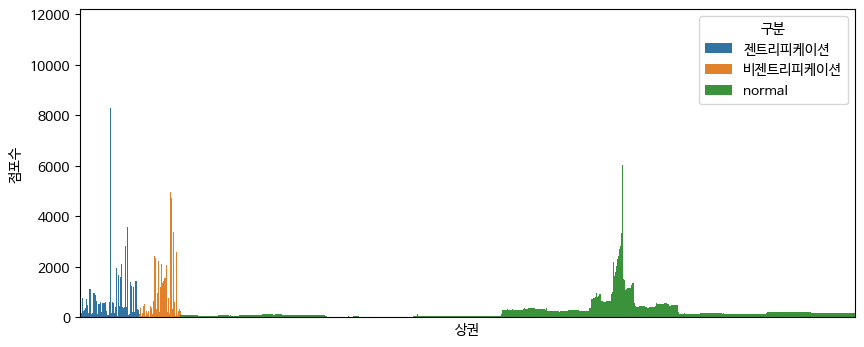

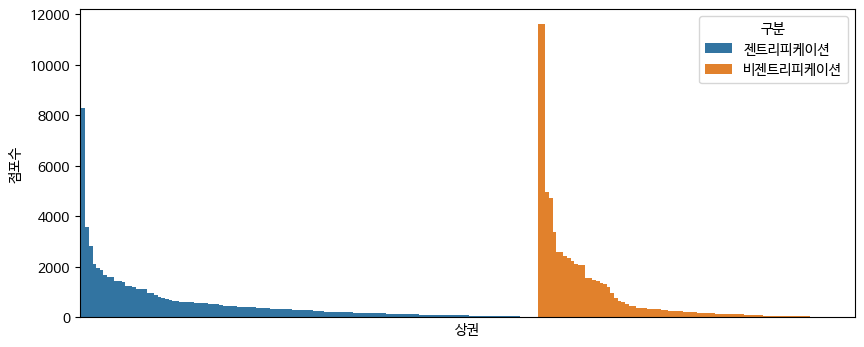

In [19]:
# 전체 점포 확인
plt.figure(figsize=(10, 4))
sns.barplot(qurt_com_now_merge.sort_values(by='구분', ascending=False), x='상권', y='점포수', hue='구분', width=2)
plt.xticks([])
plt.show()

# 젠 비젠만 전체 점포분포 확인
jen_bejen_com = qurt_com_now_merge[qurt_com_now_merge['구분'].isin(['젠트리피케이션', '비젠트리피케이션'])]
plt.figure(figsize=(10, 4))
sns.barplot(jen_bejen_com.sort_values(by=['구분', '점포수'], ascending=False), x='상권', y='점포수', hue='구분', width=2)
plt.xticks([])
plt.show()

- 젠트리피 비젠트리피 지역이 확실히 타 상권들 보다 높은 점포수를 보유하고 있음을 알수있음
  - 일부 normal쪽에서도 점포수가 많은 지역이 확인이 되는데, 나중에 머신러닝 or 다른 것을 확인할때 조금 확인해야할 필요가 있음
- 그리고 젠트리피케이션, 비젠트리피케이션의 비교분석은 약간 비슷한 분포를 보이고 있는데 그래도 저런 점포수가 압도적으로 높은 지역이 있음 한번 확인


#### 카테고리별 전체 변화량 TOP 10, LOW 10

- 다른 자료와는 다르게 이 자료는 그래도 시계열 부분에서 잘 되있는 느낌이라 볼수있는 방향성이 많음.
- 점포가 1650개로 개수가 많기 때문에 변화율 중에서 가장 차이가 큰 상황만 시각화


##### 데이터 정리


In [20]:
qurt_com_df = total_type_close_qurt.copy()
qurt_com_df.head()

,연도분기,상권구분코드,상권구분,상권코드,상권,서비스업종코드,서비스업종,점포수,유사업종점포수,개업율,개업점포수,폐업률,폐업점포수,프랜차이즈점포수
0,2019-01-01,R,전통시장,3130018,동대문문구완구거리(동대문문구완구시장),CS300043,전자상거래업,10,10,10,1,0,0,0
1,2019-01-01,D,발달상권,3120165,서래마을카페거리(서래마을),CS100007,치킨전문점,0,1,0,0,100,1,1
2,2019-01-01,D,발달상권,3120177,신논현역 1번,CS300015,가방,3,3,0,0,0,0,0
3,2019-01-01,A,골목상권,3110508,서연중학교,CS200041,사진관,6,6,17,1,0,0,0
4,2019-01-01,A,골목상권,3110241,먹골역 5번,CS300036,조명용품,2,2,0,0,0,0,0


In [21]:
# 해당 상권이 정해놓은 상권하고 merge하는 과정이 필요
qurt_com_category_merge = pd.merge(qurt_com_df, site_name, left_on='상권', right_on='상권')
qurt_com_category_merge.head()

,연도분기,상권구분코드,상권구분,상권코드_x,상권,서비스업종코드,서비스업종,점포수,유사업종점포수,개업율,개업점포수,폐업률,폐업점포수,프랜차이즈점포수,상권그룹,상권코드_y,구분
0,2019-01-01,R,전통시장,3130018,동대문문구완구거리(동대문문구완구시장),CS300043,전자상거래업,10,10,10,1,0,0,0,동대문(DDP),3130018,비젠트리피케이션
1,2019-01-01,A,골목상권,3110883,은천초등학교(은천교앞),CS200019,PC방,1,2,0,0,0,0,1,신림,3110883,젠트리피케이션
2,2019-01-01,D,발달상권,3120009,종로3가역,CS200025,자동차수리,5,6,0,0,0,0,1,북촌,3120009,젠트리피케이션
3,2019-01-01,D,발달상권,3120009,종로3가역,CS200025,자동차수리,5,6,0,0,0,0,1,종로3가,3120009,젠트리피케이션
4,2019-01-01,R,전통시장,3130248,영등포역지하도상점가,CS200037,노래방,3,3,0,0,0,0,0,영등포,3130248,비젠트리피케이션


In [22]:
import datetime

# 전체별 시계열의 변화율을 체크하고 싶음
# 더 좋은 방법이 있을꺼 같긴한데 일단 젠트리피랑 비젠트리피로 테이블을 나눠서 하는게 가장 깔끔해보임
gen_qurt_com = qurt_com_category_merge[qurt_com_category_merge['구분'].isin(['젠트리피케이션'])]
nongen_qurt_com = qurt_com_category_merge[qurt_com_category_merge['구분'].isin(['비젠트리피케이션'])]

# 각각의 피벗테이블 생성
gen_qurt_com_pivot = gen_qurt_com.pivot_table('점포수', '상권', '연도분기', aggfunc='sum')
nongen_qurt_com_pivot = nongen_qurt_com.pivot_table('점포수', '상권', '연도분기', aggfunc='sum')

# datetime 형태면 귀찮으니까 타입 정렬까지 진행
gen_qurt_com_columns = gen_qurt_com_pivot.columns.strftime('%Y-%m-%d')
gen_qurt_com_pivot.columns = gen_qurt_com_columns

nongen_qurt_com_columns = nongen_qurt_com_pivot.columns.strftime('%Y-%m-%d')
nongen_qurt_com_pivot.columns = nongen_qurt_com_columns


# 각 첫행에 있는 숫자로 나누기
# 젠트리 TOP 10
gen_top10_areas = gen_qurt_com_pivot.sort_values(by='2019-01-01', ascending=False).head(10)
gen_qurt_com_pivot_rate = gen_top10_areas.div(gen_top10_areas.iloc[:, 0], axis=0) * 100
gen_qurt_com_pivot_rate_melt = gen_qurt_com_pivot_rate.dropna(axis=1).reset_index().melt(id_vars='상권', var_name='연도분기', value_name='점포개수')

# 젠트리 LOW 10
gen_low10_areas = gen_qurt_com_pivot.sort_values(by='2019-01-01', ascending=True).head(10)
gen_low10_pivot_rate = gen_low10_areas.div(gen_low10_areas.iloc[:, 0], axis=0) * 100
gen_low10_pivot_rate_melt = gen_low10_pivot_rate.dropna(axis=1).reset_index().melt(id_vars='상권', var_name='연도분기', value_name='점포개수')

# 비젠트리 TOP 10
nongen_top10_areas = nongen_qurt_com_pivot.sort_values(by='2019-01-01', ascending=False).head(10)
nongen_qurt_com_pivot_rate = nongen_top10_areas.div(nongen_top10_areas.iloc[:, 0], axis=0) * 100
nongen_qurt_com_pivot_rate_melt = nongen_qurt_com_pivot_rate.reset_index().dropna().melt(id_vars='상권', var_name='연도분기', value_name='점포개수')

# 비젠트리 LOW 10
nongen_low10_areas = nongen_qurt_com_pivot.sort_values(by='2019-01-01', ascending=True).head(10)
nongen_low10_pivot_rate = nongen_low10_areas.div(nongen_low10_areas.iloc[:, 0], axis=0) * 100
nongen_low10_pivot_rate_melt = nongen_low10_pivot_rate.reset_index().dropna().melt(id_vars='상권', var_name='연도분기', value_name='점포개수')

In [23]:
gen_low10_areas.head()

연도분기,2019-01-01,2019-04-01,2019-07-01,2019-10-01,2020-01-01,2020-04-01,2020-07-01,2020-10-01,2021-01-01,2021-04-01,2021-07-01,2021-10-01,2022-01-01,2022-04-01,2022-07-01,2022-10-01,2023-01-01,2023-04-01,2023-07-01,2023-10-01
상권,,,,,,,,,,,,,,,,,,,,
합정시장,8,8,8,7,6,5,5,5,5,5,6,7,7,7,7,7,7,7,7,6
영진시장,10,10,11,10,11,12,12,13,14,13,13,13,12,12,12,13,12,12,11,10
체부동홍종문가옥,14,15,17,18,18,19,19,20,20,22,22,23,23,24,24,24,26,27,27,27
회현역 1번,22,22,22,21,20,20,21,22,25,24,23,24,24,22,22,21,21,21,21,21
청와대사랑채,22,22,22,24,23,23,24,24,24,26,26,27,27,27,29,29,28,28,29,28


LOW로 봤을때는 점포의 변화가 달라서 변화율이 그렇게 좋은 방법으로 작용하지 않을꺼 같아서 제외

TOP 10으로만 시각화로 해서 한번 확인해보면 좋을듯


##### 시각화


- 각 젠트리 비젠트리의 TOP 10 점포수 끼리의 변화


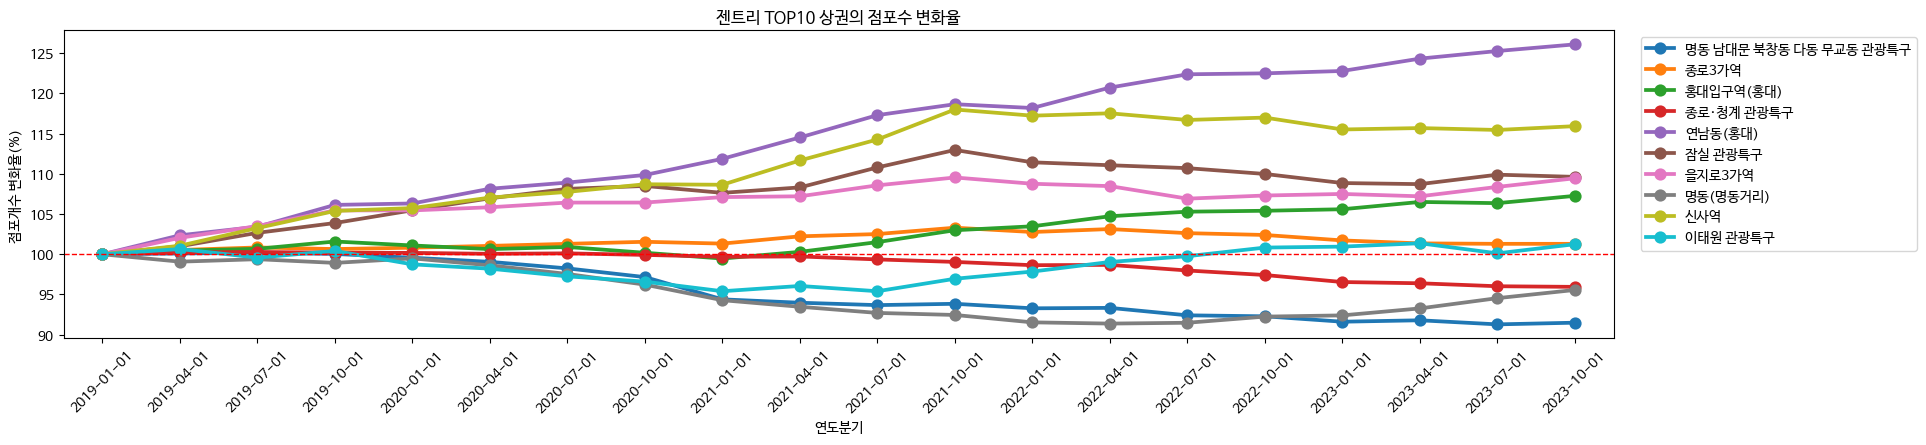

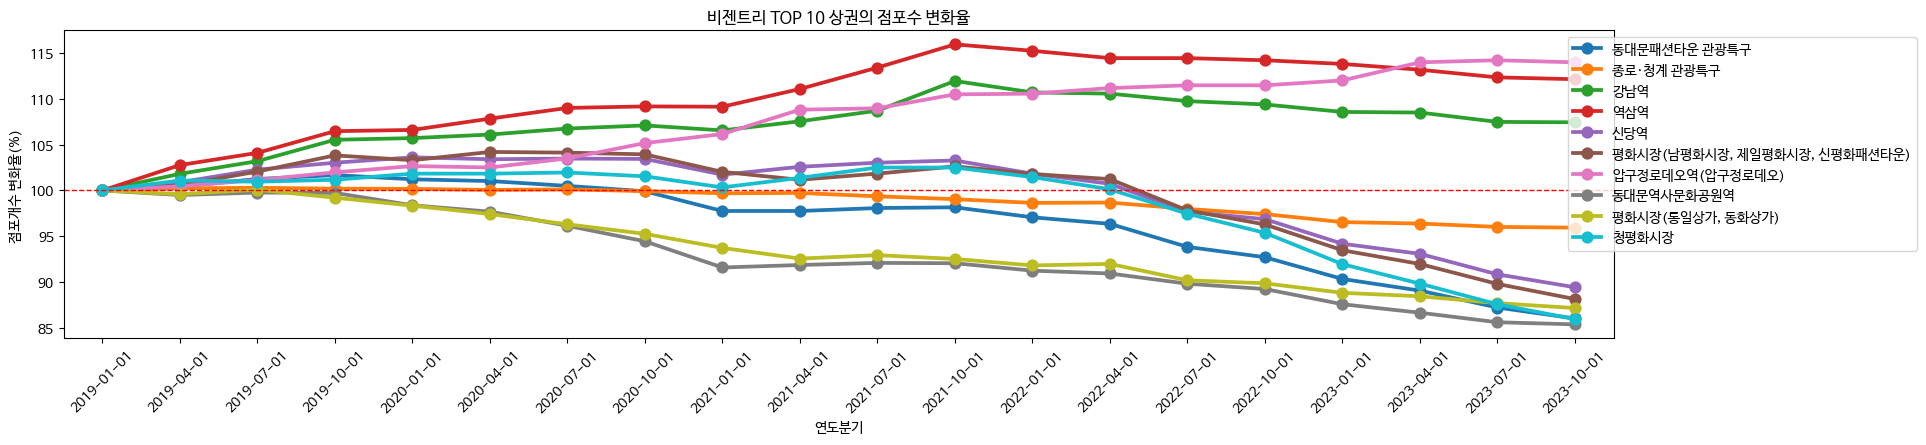

In [24]:
# 젠트리
# 각 점포수 TOP 10 변화율 시각화
plt.figure(figsize=(20, 4))
plt.title('젠트리 TOP10 상권의 점포수 변화율')
ax = sns.pointplot(gen_qurt_com_pivot_rate_melt.reset_index(), x='연도분기', y='점포개수', hue='상권')
ax.axhline(y=100, color='red', linestyle='--', linewidth=1)
plt.ylabel('점포개수 변화율(%)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.xticks(rotation=45)

# 비젠트리
# 각 점포수 TOP 10 변화율 시각화
plt.figure(figsize=(20, 4))
plt.title('비젠트리 TOP 10 상권의 점포수 변화율')
ax = sns.pointplot(nongen_qurt_com_pivot_rate_melt.reset_index(), x='연도분기', y='점포개수', hue='상권')
ax.axhline(y=100, color='red', linestyle='--', linewidth=1)
plt.ylabel('점포개수 변화율(%)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.xticks(rotation=45)

plt.show()

##### 해석

- 젠트리 지역은 상권수가 올라가고 있는 형태
- 비젠트리 지역은 상권수가 감소하고 있는 경향이 보인다
- 의견 :
  - 외의로 의미있는 해석이 나오는거 같아서 괜찮아보이네요
  - 점포수가 많은 지역만으로 뽑아서 체크해보긴 했지만 전체적으로 확인해보는 과정이 필요할꺼 같아서 바로 각 지역별로 **_선형 회귀_** 로 어떻게 분포되있는지 진행


#### 카테고리별 선형회귀 분석


##### 데이터 전처리


In [25]:
import numpy as np
from scipy import stats

# 각 상권별로 시계열 트렌드 기울기와 R² 값 계산
def calculate_slope_and_r2(row):
  x = np.arange(len(row))
  # NaN 값 제외
  mask = ~np.isnan(row)
  if np.sum(mask) > 1:  # 최소 2개 이상의 유효값이 있어야 함
    slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask], row[mask])
    r_squared = r_value**2
    return pd.Series({'slope': slope, 'r_squared': r_squared, 'p_value': p_value})
  return pd.Series({'slope': np.nan, 'r_squared': np.nan, 'p_value': np.nan})

# 젠트리피케이션 지역 분석
com_count = 800

gen_com_800over = gen_qurt_com_pivot[gen_qurt_com_pivot > com_count].dropna()
total_gen_com_rate = gen_com_800over.div(gen_com_800over.iloc[:, 0], axis=0) * 100
gen_stats = total_gen_com_rate.apply(calculate_slope_and_r2, axis=1)
gen_stats_df = gen_stats.sort_values(by='slope', ascending=True)

# 트렌드 레이블 추가
gen_stats_df['trend_label'] = ['증가' if slope > 0 else '감소' for slope in gen_stats_df['slope']]
gen_stats_df['significant'] = gen_stats_df['p_value'] < 0.05

# 비젠트리피케이션 지역 분석
nongen_com_800over = nongen_qurt_com_pivot[nongen_qurt_com_pivot > com_count].dropna()
total_nongen_com_rate = nongen_com_800over.div(nongen_com_800over.iloc[:, 0], axis=0) * 100
nongen_stats = total_nongen_com_rate.apply(calculate_slope_and_r2, axis=1)
nongen_stats_df = nongen_stats.sort_values(by='slope', ascending=True)

# 트렌드 레이블 추가
p_value = 0.05
nongen_stats_df['trend_label'] = ['증가' if slope > 0 else '감소' for slope in nongen_stats_df['slope']]
nongen_stats_df['significant'] = nongen_stats_df['p_value'] < p_value

# p-value가 0.05 미만인 데이터만 필터링
gen_stats_significant = gen_stats_df[gen_stats_df['p_value'] < p_value]
nongen_stats_significant = nongen_stats_df[nongen_stats_df['p_value'] < p_value]

##### 시각화


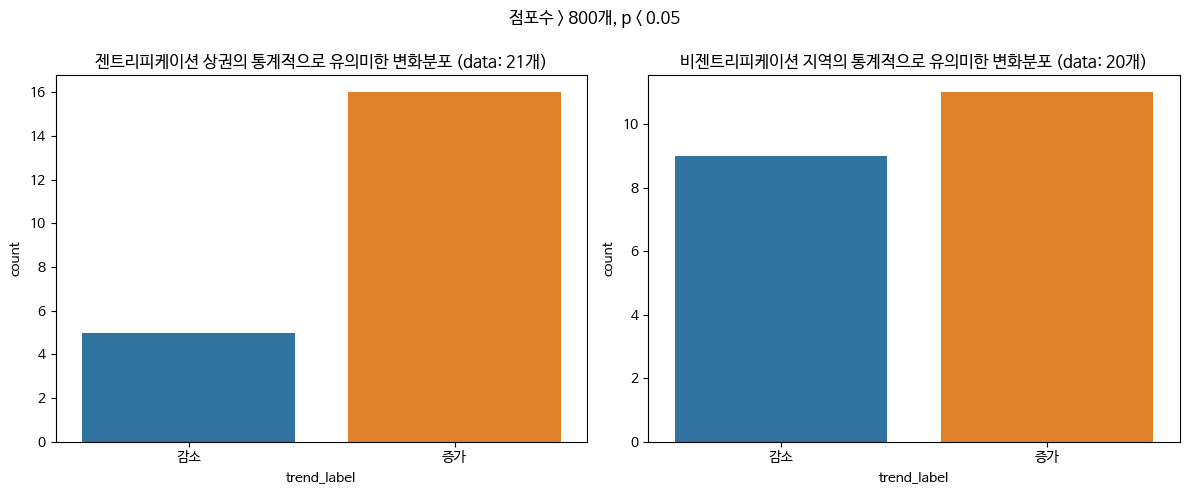

In [26]:
# 시각화
fig = plt.figure(figsize=(12, 5))
fig.suptitle(f'점포수 > {com_count}개, p < {p_value}')

# 젠트리피케이션 지역 트렌드 분포 (p < 0.05)
plt.subplot(121)
plt.title(f'젠트리피케이션 상권의 통계적으로 유의미한 변화분포 (data: {len(gen_stats_significant)}개)')
sns.countplot(gen_stats_significant, x='trend_label', hue='trend_label')

# 비젠트리피케이션 지역 트렌드 분포 (p < 0.05)
plt.subplot(122)
plt.title(f'비젠트리피케이션 지역의 통계적으로 유의미한 변화분포 (data: {len(nongen_stats_significant)}개)')
sns.countplot(nongen_stats_significant, x='trend_label', hue='trend_label')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

##### 해석

- 선형 회귀 분석 결과(p < 0.05)
- 젠트리피케이션 상권의 점포는 **증가 추세의 비율**이 많았는데, 반면 비젠트로피케이션은 젠트리 지역보다 **_감소인 추세의 비율이 많았음_**
- 이러한 시계열 데이터의 **기울기, R2, p-value**를 어느정도 군집화 할때 feature로 활용이 가능할수 있을거 같음.


#### 전체 현황 분석결과 정리

---


- <U>**2023 3분기 최신 데이터**</U> 확인결과, 점포수의 숫자나 변화를 이용할꺼면 미쳐 분리 못한 <U>**normal 지역의 상권이 많은 곳**</U>은 적절하게 처리해주는 과정이 필요할것으로 판단됨
- 젠트리 지역과 비젠트리 지역간의 시계열 변화율(2019 1분기, 2023년 3분기)을 확인한 결과, <U>**젠트리 지역은 증가의 추세, 비젠트리 지역은 감소의 추세를 보이고 있음**</U>
- 따라서 해당 데이터를 회귀분석 진행했고 <U>**점포 800개 이상**인 상권의 통계적으로 유의미한 데이터(p < 0.05)를 확인한 결과</U>,<br/>위와 똑같이 <U>**젠트리 지역은 증가의 추세, 비젠트리 지역은 감소의 추세를 보이고 있음**</U>
- 추후 해당 지역의 상권변화에 p-value나 기울기는 feature로 사용이 가능하다고 판단됨

---


### 프렌차이즈 점포 분석

- 전체 현황분석하고 같은 느낌으로 분석


#### 데이터 전처리


In [27]:
# 전처리 데이터 확인
qurt_com_category_merge.head()

,연도분기,상권구분코드,상권구분,상권코드_x,상권,서비스업종코드,서비스업종,점포수,유사업종점포수,개업율,개업점포수,폐업률,폐업점포수,프랜차이즈점포수,상권그룹,상권코드_y,구분
0,2019-01-01,R,전통시장,3130018,동대문문구완구거리(동대문문구완구시장),CS300043,전자상거래업,10,10,10,1,0,0,0,동대문(DDP),3130018,비젠트리피케이션
1,2019-01-01,A,골목상권,3110883,은천초등학교(은천교앞),CS200019,PC방,1,2,0,0,0,0,1,신림,3110883,젠트리피케이션
2,2019-01-01,D,발달상권,3120009,종로3가역,CS200025,자동차수리,5,6,0,0,0,0,1,북촌,3120009,젠트리피케이션
3,2019-01-01,D,발달상권,3120009,종로3가역,CS200025,자동차수리,5,6,0,0,0,0,1,종로3가,3120009,젠트리피케이션
4,2019-01-01,R,전통시장,3130248,영등포역지하도상점가,CS200037,노래방,3,3,0,0,0,0,0,영등포,3130248,비젠트리피케이션


In [28]:
# 전체별 시계열의 변화율을 체크하고 싶음
# 더 좋은 방법이 있을꺼 같긴한데 일단 젠트리피랑 비젠트리피로 테이블을 나눠서 하는게 가장 깔끔해보임
gen_qurt_fren = qurt_com_category_merge[qurt_com_category_merge['구분'].isin(['젠트리피케이션'])]
nongen_qurt_fren = qurt_com_category_merge[qurt_com_category_merge['구분'].isin(['비젠트리피케이션'])]

# 각각의 피벗테이블 생성
gen_qurt_fren_pivot = gen_qurt_fren.pivot_table('프랜차이즈점포수', '상권', '연도분기', aggfunc='sum')
nongen_qurt_fren_pivot = nongen_qurt_fren.pivot_table('프랜차이즈점포수', '상권', '연도분기', aggfunc='sum')

# datetime 형태면 귀찮으니까 타입 정렬까지 진행
gen_qurt_fren_columns = gen_qurt_fren_pivot.columns.strftime('%Y-%m-%d')
gen_qurt_fren_pivot.columns = gen_qurt_fren_columns

nongen_qurt_fren_columns = nongen_qurt_fren_pivot.columns.strftime('%Y-%m-%d')
nongen_qurt_fren_pivot.columns = nongen_qurt_fren_columns

# 각 첫행에 있는 숫자로 나누기
# 젠트리 TOP 10
gen_top10_areas = gen_qurt_fren_pivot.sort_values(by='2019-01-01', ascending=False).head(10)
gen_qurt_fren_pivot_rate = gen_top10_areas.div(gen_top10_areas.iloc[:, 0], axis=0) * 100
gen_qurt_fren_pivot_rate_melt = gen_qurt_fren_pivot_rate.dropna(axis=1).reset_index().melt(id_vars='상권', var_name='연도분기', value_name='프랜차이즈개수')

# 비젠트리 TOP 10
nongen_top10_areas = nongen_qurt_fren_pivot.sort_values(by='2019-01-01', ascending=False).head(10)
nongen_qurt_fren_pivot_rate = nongen_top10_areas.div(nongen_top10_areas.iloc[:, 0], axis=0) * 100
nongen_qurt_fren_pivot_rate_melt = nongen_qurt_fren_pivot_rate.reset_index().dropna().melt(id_vars='상권', var_name='연도분기', value_name='프랜차이즈개수')


# 수정이 필요
# 전체 프랜차이즈 말고 최신의 프랜차이즈만 확인이 필요.
print(f'젠트리 프랜차이즈 점포 개수 : {len(gen_qurt_fren[gen_qurt_fren["연도분기"].isin(["2023-10-01"])])}')
print(f'젠트리 프랜차이즈 점포 개수 : {len(nongen_qurt_fren[nongen_qurt_fren["연도분기"].isin(["2023-10-01"])])}')

젠트리 프랜차이즈 점포 개수 : 7988
젠트리 프랜차이즈 점포 개수 : 4201


/tmp/ipykernel_18943/1447783109.py:31: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  print(f'젠트리 프랜차이즈 점포 개수 : {len(gen_qurt_fren[gen_qurt_fren["연도분기"].isin(["2023-10-01"])])}')
/tmp/ipykernel_18943/1447783109.py:32: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  print(f'젠트리 프랜차이즈 점포 개수 : {len(nongen_qurt_fren[nongen_qurt_fren["연도분기"].isin(["2023-10-01"])])}')


#### 시각화


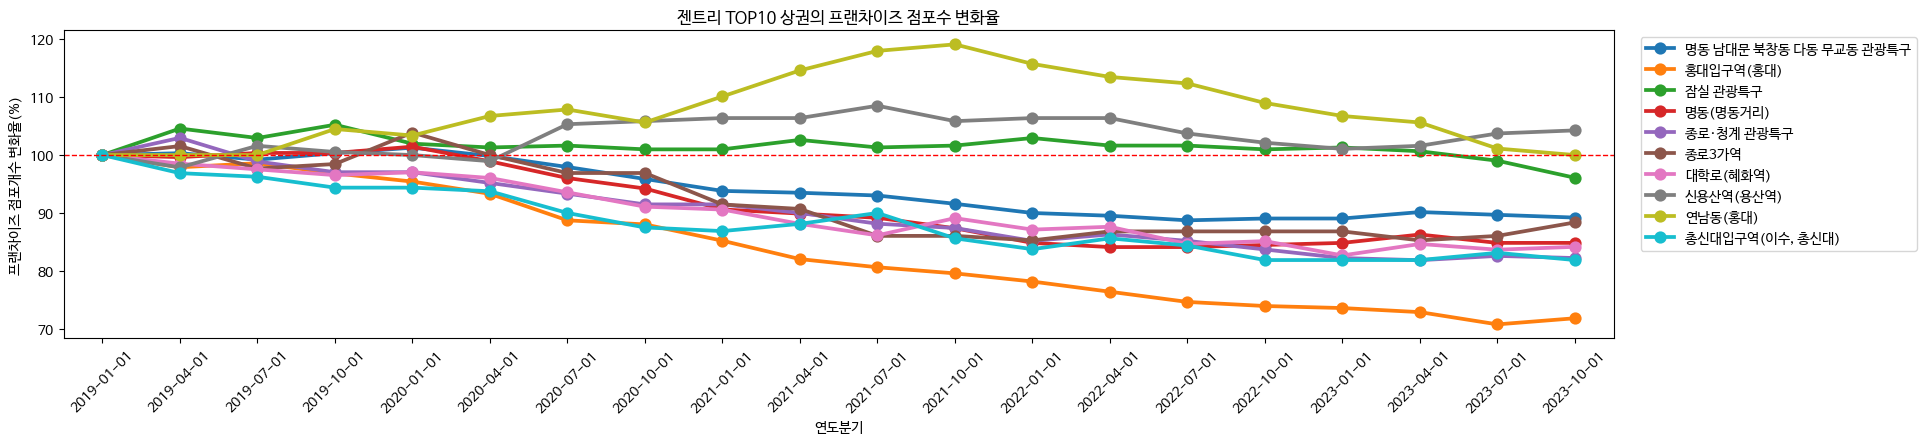

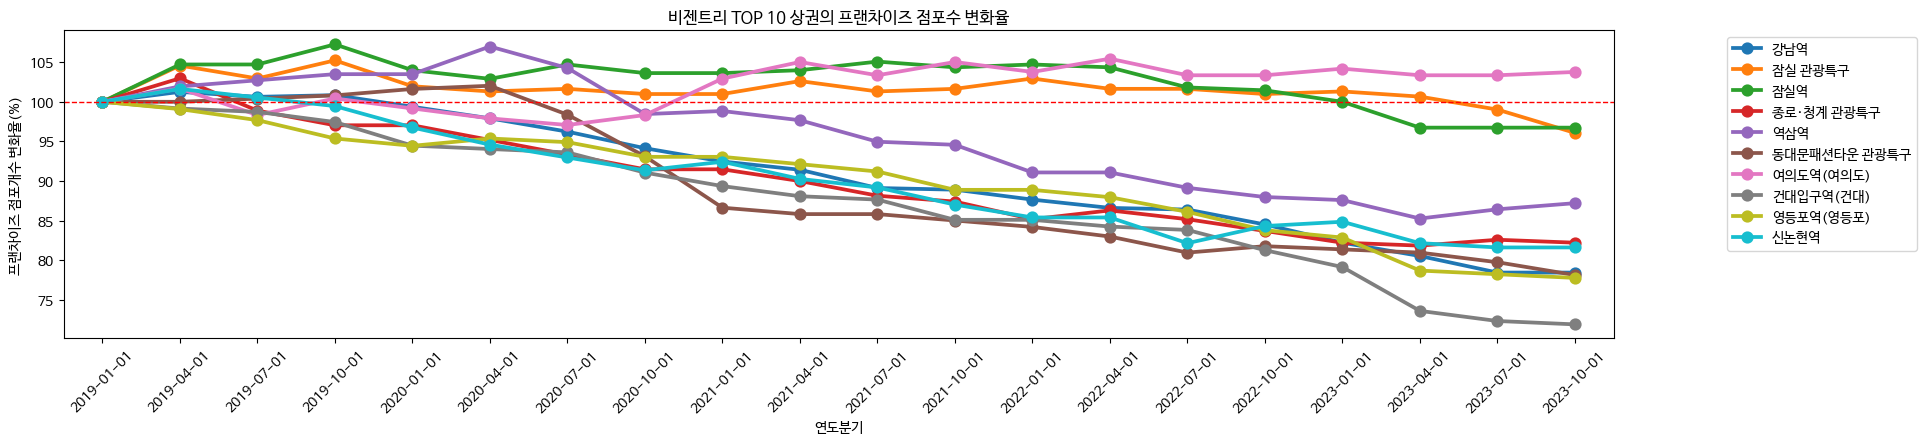

In [29]:
# 젠트리
# 각 점포수 TOP 10 변화율 시각화
plt.figure(figsize=(20, 4))
plt.title('젠트리 TOP10 상권의 프랜차이즈 점포수 변화율')
ax = sns.pointplot(gen_qurt_fren_pivot_rate_melt.reset_index(), x='연도분기', y='프랜차이즈개수', hue='상권')
ax.axhline(y=100, color='red', linestyle='--', linewidth=1)
plt.ylabel('프랜차이즈 점포개수 변화율(%)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.xticks(rotation=45)

# 비젠트리
# 각 점포수 TOP 10 변화율 시각화
plt.figure(figsize=(20, 4))
plt.title('비젠트리 TOP 10 상권의 프랜차이즈 점포수 변화율')
ax = sns.pointplot(nongen_qurt_fren_pivot_rate_melt.reset_index(), x='연도분기', y='프랜차이즈개수', hue='상권')
ax.axhline(y=100, color='red', linestyle='--', linewidth=1)
plt.ylabel('프랜차이즈 점포개수 변화율(%)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.xticks(rotation=45)

plt.show()

- 프랜차이즈는 보면 전체적으로 보면 하향하는 추세
- 이거는 점포별 카테고리 별로 한번 더 확인하는 방식으로 보는게 맞는듯 싶다.


In [30]:
# 각각의 피벗테이블 생성
gen_qurt_fren_pivot = gen_qurt_fren.pivot_table('프랜차이즈점포수', '서비스업종', '연도분기', aggfunc='sum')
nongen_qurt_fren_pivot = nongen_qurt_fren.pivot_table('프랜차이즈점포수', '서비스업종', '연도분기', aggfunc='sum')

# datetime 형태면 귀찮으니까 타입 정렬까지 진행
gen_qurt_fren_columns = gen_qurt_fren_pivot.columns.strftime('%Y-%m-%d')
gen_qurt_fren_pivot.columns = gen_qurt_fren_columns

nongen_qurt_fren_columns = nongen_qurt_fren_pivot.columns.strftime('%Y-%m-%d')
nongen_qurt_fren_pivot.columns = nongen_qurt_fren_columns


# 각 첫행에 있는 숫자로 나누기
# 젠트리 프렌차이즈 업종별 TOP 10
gen_top10_areas = gen_qurt_fren_pivot.sort_values(by='2019-01-01', ascending=False).head(10)
gen_qurt_fren_pivot_rate = gen_top10_areas.div(gen_top10_areas.iloc[:, 0], axis=0) * 100
gen_qurt_fren_pivot_rate_melt = gen_qurt_fren_pivot_rate.dropna(axis=1).reset_index().melt(id_vars='서비스업종', var_name='연도분기', value_name='프랜차이즈개수')

# 비젠트리 프렌차이즈 업종별 TOP 10
nongen_top10_areas = nongen_qurt_fren_pivot.sort_values(by='2019-01-01', ascending=False).head(10)
nongen_qurt_fren_pivot_rate = nongen_top10_areas.div(nongen_top10_areas.iloc[:, 0], axis=0) * 100
nongen_qurt_fren_pivot_rate_melt = nongen_qurt_fren_pivot_rate.reset_index().dropna().melt(id_vars='서비스업종', var_name='연도분기', value_name='프랜차이즈개수')

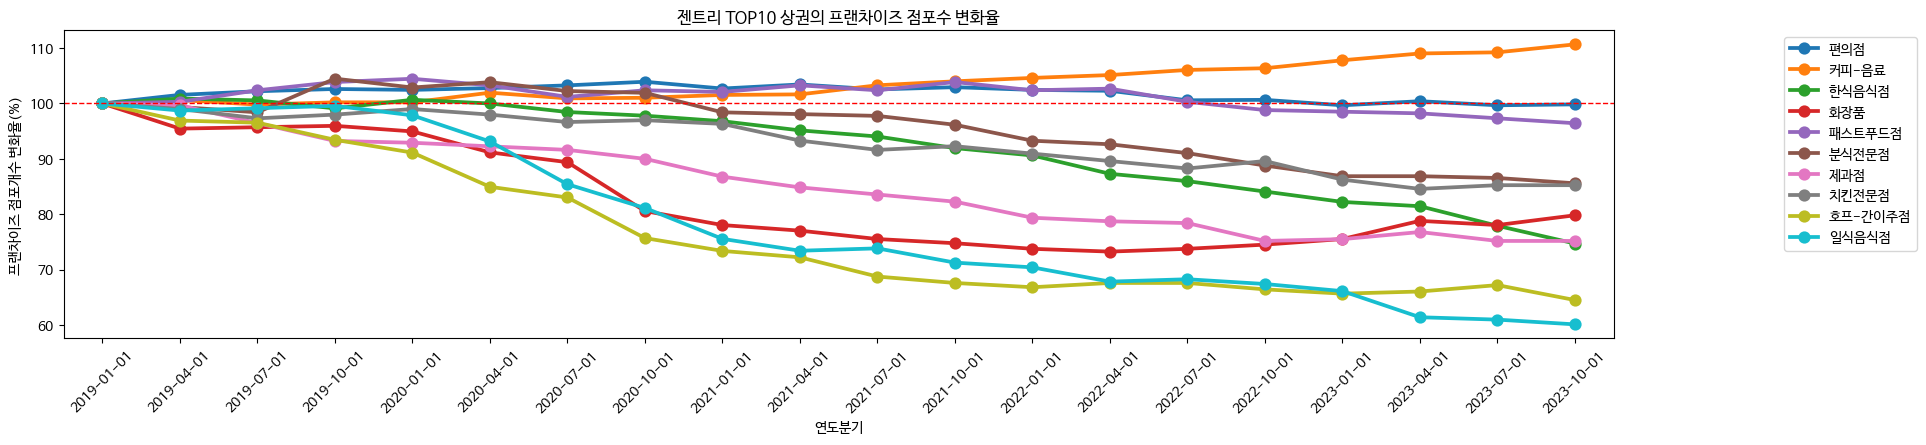

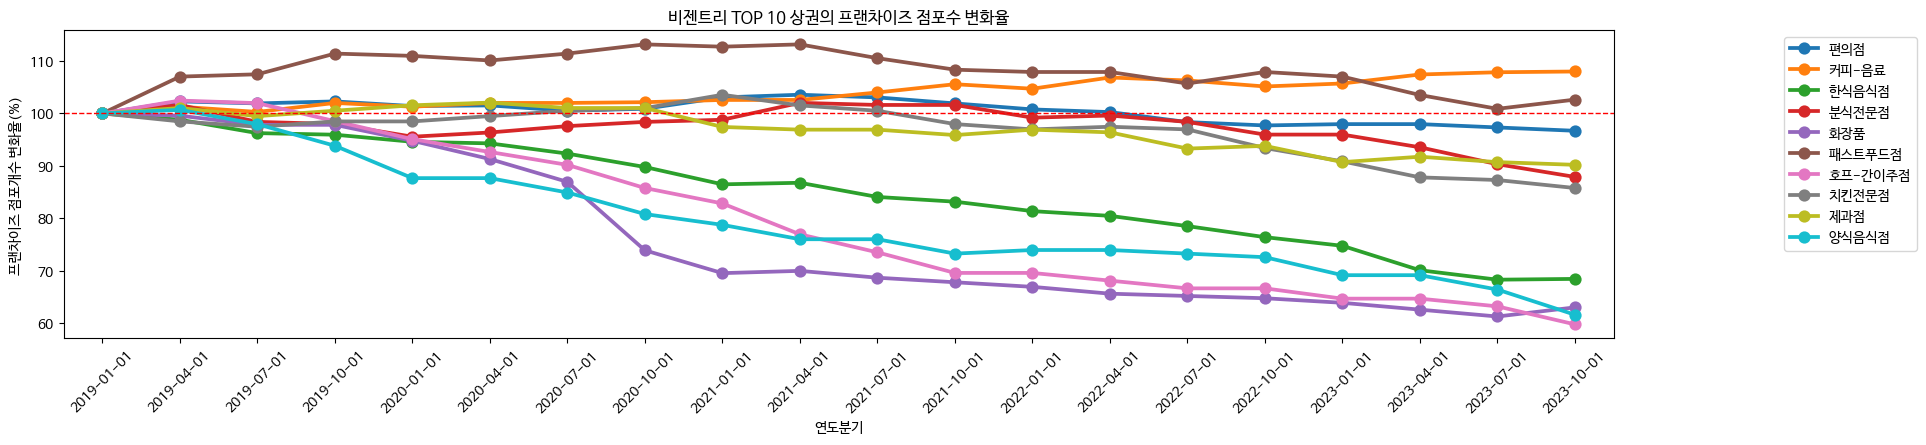

In [31]:
# 젠트리
# 각 업종별 점포수 TOP 10 변화율 시각화
plt.figure(figsize=(20, 4))
plt.title('젠트리 TOP10 상권의 프랜차이즈 점포수 변화율')
ax = sns.pointplot(gen_qurt_fren_pivot_rate_melt.reset_index(), x='연도분기', y='프랜차이즈개수', hue='서비스업종')
ax.axhline(y=100, color='red', linestyle='--', linewidth=1)
plt.ylabel('프랜차이즈 점포개수 변화율(%)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.xticks(rotation=45)

# 비젠트리
# 각 업종별 TOP 10 변화율 시각화
plt.figure(figsize=(20, 4))
plt.title('비젠트리 TOP 10 상권의 프랜차이즈 점포수 변화율')
ax = sns.pointplot(nongen_qurt_fren_pivot_rate_melt.reset_index(), x='연도분기', y='프랜차이즈개수', hue='서비스업종')
ax.axhline(y=100, color='red', linestyle='--', linewidth=1)
plt.ylabel('프랜차이즈 점포개수 변화율(%)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.xticks(rotation=45)

plt.show()

- 이거 보면 프렌차이즈 업종이 많이 감소되고 있어 프랜차이즈 별로 감소되고 있다는 가설이 좀 부정이됨.
- 그나마 인사이트를 찾는다고 하면 커피 업종이 계속 상승세로 유지되고 있다는것..


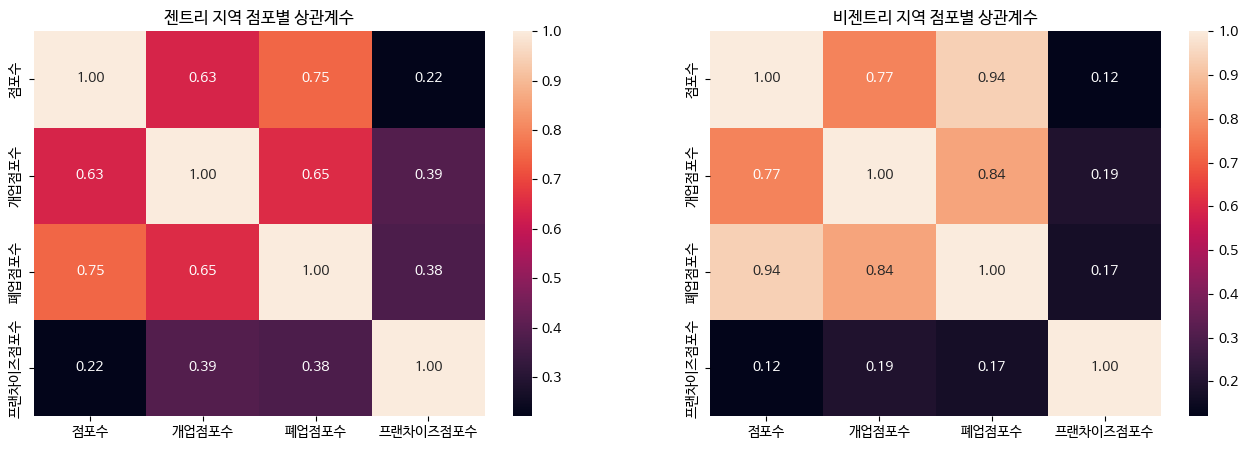

In [32]:
# 혹시 모르니까 점포수와의 상관관계를 한번보자
plt.figure(figsize=(16, 5))

plt.subplot(121)
plt.title('젠트리 지역 점포별 상관계수')
sns.heatmap(
    gen_qurt_fren.drop(['상권코드_x', '상권코드_y', '유사업종점포수', '개업율', '폐업률'], axis=1).select_dtypes(include=['float64', 'int64']).corr(),
    annot=True,
    fmt='.2f'
)

plt.subplot(122)
plt.title('비젠트리 지역 점포별 상관계수')
sns.heatmap(
    nongen_qurt_fren.drop(['상권코드_x', '상권코드_y', '유사업종점포수', '개업율', '폐업률'], axis=1).select_dtypes(include=['float64', 'int64']).corr(),
    annot=True,
    fmt='.2f'
)
plt.show()

In [33]:
gen_qurt_fren.drop(['상권코드_x', '상권코드_y', '유사업종점포수', '개업율', '폐업률'], axis=1).select_dtypes(include=['float64', 'int64']).corr()

,점포수,개업점포수,폐업점포수,프랜차이즈점포수
점포수,1.000000,0.634545,0.749130,0.220361
개업점포수,0.634545,1.000000,0.650973,0.388979
폐업점포수,0.749130,0.650973,1.000000,0.377012
프랜차이즈점포수,0.220361,0.388979,0.377012,1.000000


In [34]:
nongen_qurt_fren.drop(['상권코드_x', '상권코드_y', '유사업종점포수', '개업율', '폐업률'], axis=1).select_dtypes(include=['float64', 'int64']).corr()

,점포수,개업점포수,폐업점포수,프랜차이즈점포수
점포수,1.000000,0.772764,0.936609,0.119943
개업점포수,0.772764,1.000000,0.841798,0.192239
폐업점포수,0.936609,0.841798,1.000000,0.169262
프랜차이즈점포수,0.119943,0.192239,0.169262,1.000000


#### 분석 결과 요약

---


- 전체적으로 젠트리와 비젠트리 둘 다 <U>**프랜차이즈의 점포수는 계속 감소**</U>하는 추세
- <U>**점포간의 강한 상관성을 찾기가 힘듬..(상관관계 0.38 정도)**</U>
- 관계성을 찾기 위해서는 임대료에 관한 데이터가 필요할 것으로 예상됨.
- 근데 임대료 데이터 봐도... 그때 예전에 수미님이 하신거 보면 임대료는 상승중인데 점포는 떨어지는 중이니까. 살짝... 음의관계가 나와서 변수로는 사용이 불가능 할수 있음
- 그래도 나중에 확인해 봤을 때, 상관관계가 높게 나오면 적용은 가능할 것으로 보임

---


## 매출 관련 데이터 분석


### 데이터 정리


In [35]:
# 누가 영어명으로 정리해주신거 있어서 사용
# 데이터 가져오기
total_sales_df = pd.DataFrame(None)

for year in range(2019, 2024):
  total_sales_df = pd.concat([total_sales_df, globals()[f"df_estimated_sales_{year}"]])
print(f'수집된 데이터는 {len(total_sales_df)}개 입니다')

columns = [
    '당월매출금액', '당월매출건수', '주중매출금액', '주말매출금액', '월요일매출금액',
    '화요일매출금액', '수요일매출금액', '목요일매출금액', '금요일매출금액', '토요일매출금액',
    '일요일매출금액', '시간대0006매출금액', '시간대0611매출금액', '시간대1114매출금액',
    '시간대1417매출금액', '시간대1721매출금액', '시간대2124매출금액', '남성매출금액',
    '여성매출금액', '연령대10매출금액', '연령대20매출금액', '연령대30매출금액', '연령대40매출금액',
    '연령대50매출금액', '연령대60이상매출금액', '주중매출건수', '주말매출건수', '월요일매출건수',
    '화요일매출건수', '수요일매출건수', '목요일매출건수', '금요일매출건수', '토요일매출건수',
    '일요일매출건수', '시간대건수06매출건수', '시간대건수11매출건수', '시간대건수14매출건수',
    '시간대건수17매출건수', '시간대건수21매출건수', '시간대건수24매출건수', '남성매출건수',
    '여성매출건수', '연령대10매출건수', '연령대20매출건수', '연령대30매출건수',
    '연령대40매출건수', '연령대50매출건수', '연령대60이상매출건수'
]

for col in columns:
  total_sales_df[col] = pd.to_numeric(total_sales_df[col], errors='coerce')

total_sales_df['연도분기'] = total_sales_df['연도분기'].apply(time_to_quarter)

total_sales_df.head()

수집된 데이터는 407724개 입니다


,연도분기,상권구분코드,상권구분,상권코드,상권,서비스업종코드,서비스업종,당월매출금액,당월매출건수,주중매출금액,...,시간대건수21매출건수,시간대건수24매출건수,남성매출건수,여성매출건수,연령대10매출건수,연령대20매출건수,연령대30매출건수,연령대40매출건수,연령대50매출건수,연령대60이상매출건수
0,2019-01-01,D,발달상권,3120051,뚝섬역,CS300033,철물점,10036503,543,6500466,...,68,0,249,114,0,0,114,204,0,46
1,2019-01-01,D,발달상권,3120052,성수역,CS300033,철물점,17703525,803,17703525,...,37,0,585,37,0,37,37,146,219,183
2,2019-01-01,A,골목상권,3110139,자양4동주민센터,CS300033,철물점,18322463,584,14534910,...,28,14,326,95,0,14,68,96,122,122
3,2019-01-01,A,골목상권,3110358,인수동 우편취급국,CS300033,철물점,42726644,765,42576436,...,192,0,328,136,0,82,109,54,110,110
4,2019-01-01,D,발달상권,3120192,뱅뱅사거리,CS300033,철물점,65022729,1990,63566874,...,164,0,1217,328,0,117,281,187,422,538


In [36]:
# 점포 데이터랑 이을수 있을거 같아서 조인좀 해보기
total_sales_com = pd.merge(total_sales_df, total_type_close, left_on=['연도분기', '상권', '서비스업종코드'], right_on=['연도분기', '상권', '서비스업종코드'])

# 어 되네?.., 확인결과 점포수가 더 많은 데이터로 가지고 있는거 같은데 나중에 상관관계 정도도 봐도 좋을꺼 같아서 일단 조인
total_sales_com.head()

,연도분기,상권구분코드_x,상권구분_x,상권코드_x,상권,서비스업종코드,서비스업종_x,당월매출금액,당월매출건수,주중매출금액,...,상권구분_y,상권코드_y,서비스업종_y,점포수,유사업종점포수,개업율,개업점포수,폐업률,폐업점포수,프랜차이즈점포수
0,2019-01-01,D,발달상권,3120051,뚝섬역,CS300033,철물점,10036503,543,6500466,...,발달상권,3120051,철물점,4,4,0,0,0,0,0
1,2019-01-01,D,발달상권,3120052,성수역,CS300033,철물점,17703525,803,17703525,...,발달상권,3120052,철물점,7,7,0,0,0,0,0
2,2019-01-01,A,골목상권,3110139,자양4동주민센터,CS300033,철물점,18322463,584,14534910,...,골목상권,3110139,철물점,3,3,0,0,0,0,0
3,2019-01-01,A,골목상권,3110358,인수동 우편취급국,CS300033,철물점,42726644,765,42576436,...,골목상권,3110358,철물점,3,3,0,0,0,0,0
4,2019-01-01,D,발달상권,3120192,뱅뱅사거리,CS300033,철물점,65022729,1990,63566874,...,발달상권,3120192,철물점,6,6,0,0,33,2,0


In [37]:
site_name.head()

,상권그룹,상권코드,상권,구분
0,강남역,3120189,강남역,비젠트리피케이션
2,강남역,3120197,역삼역,비젠트리피케이션
3,강남역,3120187,신논현역,비젠트리피케이션
4,강남역,3110954,국기원,비젠트리피케이션
5,압구정로데오,3120195,성수대교남단,비젠트리피케이션


In [38]:
# 어느 지점인지 위치에 따른 조인'
total_sales_com_category = pd.merge(total_sales_com, site_name, left_on='상권', right_on='상권')
total_sales_com_category.head()

,연도분기,상권구분코드_x,상권구분_x,상권코드_x,상권,서비스업종코드,서비스업종_x,당월매출금액,당월매출건수,주중매출금액,...,점포수,유사업종점포수,개업율,개업점포수,폐업률,폐업점포수,프랜차이즈점포수,상권그룹,상권코드,구분
0,2019-01-01,D,발달상권,3120051,뚝섬역,CS300033,철물점,10036503,543,6500466,...,4,4,0,0,0,0,0,성수동,3120051,젠트리피케이션
1,2019-01-01,D,발달상권,3120052,성수역,CS300033,철물점,17703525,803,17703525,...,7,7,0,0,0,0,0,성수동,3120052,젠트리피케이션
2,2019-01-01,R,전통시장,3130246,영등포청과시장(조광시장),CS300033,철물점,2175722,85,2175722,...,3,3,0,0,0,0,0,문래,3130246,젠트리피케이션
3,2019-01-01,D,발달상권,3120178,신사역,CS300033,철물점,41827777,1572,38263396,...,4,4,0,0,0,0,0,신사동 가로수길,3120178,젠트리피케이션
4,2019-01-01,D,발달상권,3120008,인사동,CS300035,인테리어,713975246,8686,565829157,...,21,21,14,3,5,1,0,북촌,3120008,젠트리피케이션


In [39]:
id_sales_columns = ['연도분기', '상권', '서비스업종코드', '서비스업종_x', '구분', '상권그룹']
des_sales_columns = ['당월매출금액', '주중매출금액', '주말매출금액']
week_sales_columns = ['월요일매출금액', '화요일매출금액', '수요일매출금액', '목요일매출금액', '금요일매출금액', '토요일매출금액', '일요일매출금액', '주중매출금액', '주말매출금액']
times_sales_columns = ['시간대0006매출금액', '시간대0611매출금액', '시간대1114매출금액', '시간대1417매출금액', '시간대1721매출금액', '시간대2124매출금액']
com_sales_columns = ['점포수', '프랜차이즈점포수']

des_sales_df = total_sales_com_category[id_sales_columns + des_sales_columns + com_sales_columns]
week_sales_df = total_sales_com_category[id_sales_columns + week_sales_columns + com_sales_columns]
times_sales_df = total_sales_com_category[id_sales_columns + times_sales_columns + com_sales_columns]

des_sales_df.head()

,연도분기,상권,서비스업종코드,서비스업종_x,구분,상권그룹,당월매출금액,주중매출금액,주말매출금액,점포수,프랜차이즈점포수
0,2019-01-01,뚝섬역,CS300033,철물점,젠트리피케이션,성수동,10036503,6500466,3536037,4,0
1,2019-01-01,성수역,CS300033,철물점,젠트리피케이션,성수동,17703525,17703525,0,7,0
2,2019-01-01,영등포청과시장(조광시장),CS300033,철물점,젠트리피케이션,문래,2175722,2175722,0,3,0
3,2019-01-01,신사역,CS300033,철물점,젠트리피케이션,신사동 가로수길,41827777,38263396,3564381,4,0
4,2019-01-01,인사동,CS300035,인테리어,젠트리피케이션,북촌,713975246,565829157,148146089,21,0


구현 해야할것

- 점포수 별 당월*매출금액 = 주중*매출*금액 / 점포*수
- 일반 점포수 = 점포*수 - 프랜차이즈*점포\_수 (일부 음수 나오는 것을 보아 전체 점포로 책정해야할듯)
- 전체 점포수 = 점포*수 + 프랜차이즈*점포\_수수


In [40]:
des_sales_df['전체점포수'] = des_sales_df['점포수'] + des_sales_df['프랜차이즈점포수']
des_sales_df['점포별당월매출금액'] = des_sales_df['당월매출금액'] / des_sales_df['점포수']
des_sales_df = des_sales_df.replace([np.inf, -np.inf], np.nan)
des_sales_df.head()

/tmp/ipykernel_18943/2886459730.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  des_sales_df['전체점포수'] = des_sales_df['점포수'] + des_sales_df['프랜차이즈점포수']
/tmp/ipykernel_18943/2886459730.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  des_sales_df['점포별당월매출금액'] = des_sales_df['당월매출금액'] / des_sales_df['점포수']


,연도분기,상권,서비스업종코드,서비스업종_x,구분,상권그룹,당월매출금액,주중매출금액,주말매출금액,점포수,프랜차이즈점포수,전체점포수,점포별당월매출금액
0,2019-01-01,뚝섬역,CS300033,철물점,젠트리피케이션,성수동,10036503,6500466,3536037,4,0,4,2.509126e+06
1,2019-01-01,성수역,CS300033,철물점,젠트리피케이션,성수동,17703525,17703525,0,7,0,7,2.529075e+06
2,2019-01-01,영등포청과시장(조광시장),CS300033,철물점,젠트리피케이션,문래,2175722,2175722,0,3,0,3,7.252407e+05
3,2019-01-01,신사역,CS300033,철물점,젠트리피케이션,신사동 가로수길,41827777,38263396,3564381,4,0,4,1.045694e+07
4,2019-01-01,인사동,CS300035,인테리어,젠트리피케이션,북촌,713975246,565829157,148146089,21,0,21,3.399882e+07


### 카테고리 주소의 점포단위별 당월 매출 금액


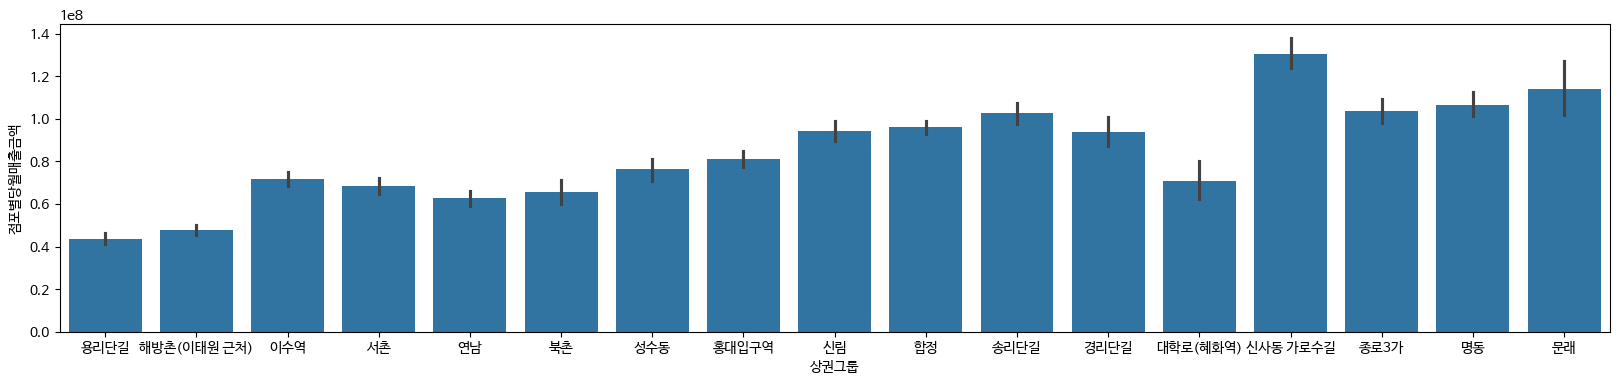

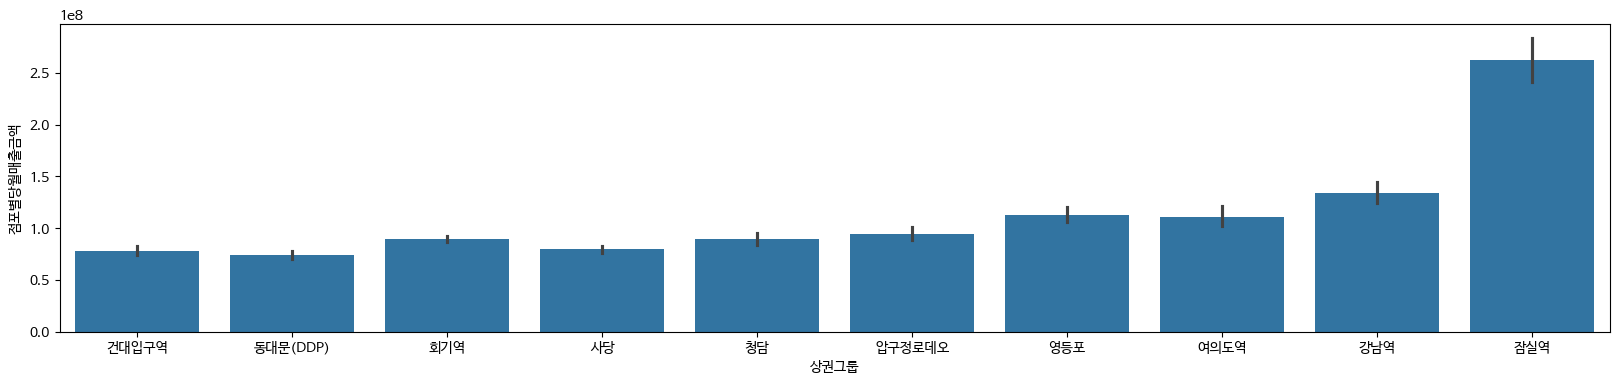

In [41]:
gen_site_sales = des_sales_df[des_sales_df['구분'] == '젠트리피케이션']
nongen_site_sales = des_sales_df[des_sales_df['구분'] == '비젠트리피케이션']

gen_site_sales_pivot = gen_site_sales.pivot_table(values='점포별당월매출금액', columns='연도분기', index='상권그룹').dropna()
nongen_site_sales_pivot = nongen_site_sales.pivot_table(values='점포별당월매출금액', columns='연도분기', index='상권그룹').dropna()

# datetime 형태면 귀찮으니까 타입 정렬까지 진행
gen_site_fren_columns = gen_site_sales_pivot.columns.strftime('%Y-%m-%d')
gen_site_sales_pivot.columns = gen_site_fren_columns

nongen_site_fren_columns = nongen_site_sales_pivot.columns.strftime('%Y-%m-%d')
nongen_site_sales_pivot.columns = nongen_site_fren_columns

# log10_gen_site_sales_pivot = np.log10(gen_site_sales_pivot) # 좀 단위가 높아서 로그스케일 진행 / 취소
gen_site_sales_melt = gen_site_sales_pivot.reset_index().sort_values(by='2023-10-01').melt(id_vars='상권그룹', var_name='연도분기', value_name='점포별당월매출금액')
plt.figure(figsize=(20, 4))
sns.barplot(data=gen_site_sales_melt, x='상권그룹', y='점포별당월매출금액', estimator='mean')

nongen_site_sales_melt = nongen_site_sales_pivot.reset_index().sort_values(by='2023-10-01').melt(id_vars='상권그룹', var_name='연도분기', value_name='점포별당월매출금액')
plt.figure(figsize=(20, 4))
sns.barplot(data=nongen_site_sales_melt, x='상권그룹', y='점포별당월매출금액', estimator='mean')
plt.show()

- 지역별로 점포별 당월 매출 금액의 차이를 보니까 그렇다할 결과물은 안나옴
- 다른 방식으로좀 진행해야할꺼 같음


<Axes: >

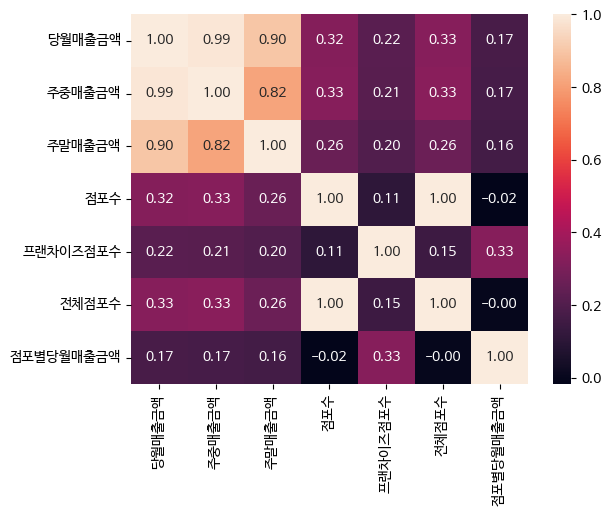

In [42]:
metrix = des_sales_df.drop(id_sales_columns, axis=1).select_dtypes(include=['float64', 'int64']).corr()

sns.heatmap(metrix, fmt=".2f", annot=True)

In [43]:
metrix

,당월매출금액,주중매출금액,주말매출금액,점포수,프랜차이즈점포수,전체점포수,점포별당월매출금액
당월매출금액,1.000000,0.987119,0.898438,0.321035,0.217275,0.327888,0.174528
주중매출금액,0.987119,1.000000,0.816616,0.328320,0.213595,0.334994,0.170260
주말매출금액,0.898438,0.816616,1.000000,0.257086,0.197628,0.263493,0.162337
점포수,0.321035,0.328320,0.257086,1.000000,0.108910,0.999252,-0.017348
프랜차이즈점포수,0.217275,0.213595,0.197628,0.108910,1.000000,0.147273,0.326691
전체점포수,0.327888,0.334994,0.263493,0.999252,0.147273,1.000000,-0.004649
점포별당월매출금액,0.174528,0.170260,0.162337,-0.017348,0.326691,-0.004649,1.000000
